# Data

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
import yfinance as yf

In [3]:
# the 1h data only available within 2 years
sp500 = yf.download("^GSPC", start="2021-04-26", end="2023-04-25", interval="1h")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^GSPC: 1h data not available for startTime=1619409600 and endTime=1682395200. The requested range must be within the last 730 days.


In [23]:
sp500 = sp500['Adj Close'] - sp500['Open']

In [32]:
sp500.values

array([ 2.81982422,  1.33007812, -5.31005859, ...,  2.62011719,
        2.75      ,  2.83984375])

## Modeling

In [19]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
import math
import numpy as np
import random
from collections import deque

2023-04-27 10:49:12.450798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The Agent code begins with some basic initializations for the various parameters. Some static variables like gamma, epsilon, epsilon_min, and epsilon_decay are defined. These are threshold constant values that are used to drive the entire buying and selling process for stock and keep the parameters in stride. These min and decay values serve like threshold values in the normal distribution.

The agent designs the layered neural network model to take action of either buy, sell, or hold. This kind of action it takes by looking at its previous prediction and also the current environment state. The act method is used to predict the next action to be taken. If the memory gets full, there is another method called expReplay designed to reset the memory.

In [118]:
class Agent:
        def __init__(self, state_size, is_eval=False, model_name=""):
            self.state_size = state_size # normalized previous days
            self.action_size = 3 # sit, buy, sell
            self.memory = deque(maxlen=1000)
            self.inventory = []
            self.model_name = model_name
            self.is_eval = is_eval
            self.gamma = 0.95
            self.epsilon = 1.0
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.995
            self.model = load_model(model_name) if is_eval else self._model()
            self.loss_l = []
            self.val_loss_l = []

        def _model(self):
            model = Sequential()
            model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
            model.add(Dense(units=32, activation="relu"))
            model.add(Dense(units=8, activation="relu"))
            model.add(Dense(self.action_size, activation="linear"))
            model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
            return model

        def act(self, state):
            if not self.is_eval and random.random()<= self.epsilon:
                return random.randrange(self.action_size)
            options = self.model.predict(state, verbose=0)
            return np.argmax(options[0])

        def expReplay(self, batch_size):
            mini_batch = []
            l = len(self.memory)
            for i in range(l - batch_size + 1, l):
                mini_batch.append(self.memory[i])
            for state, action, reward, next_state, done in mini_batch:
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
                target_f = self.model.predict(state, verbose=0)
                target_f[0][action] = target
                train_history = self.model.fit(state, target_f, epochs=1, verbose=0)
                self.loss_l.append(train_history.history['loss'])
                #self.val_loss_l.append(train_history.history['val_loss'])
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

Define Basic Functions
The formatprice() is written to structure the format of the currency. The getStockDataVec() will bring the stock data into python. Define the sigmoid function as a mathematical calculation. The getState() is coded in such a manner that it gives the current state of the data.

In [88]:
def formatPrice(n):
    return("-Rs." if n<0 else "Rs.")+"{0:.2f}".format(abs(n))
#def getStockDataVec(key):
#    vec = []
#    lines = open(key+".csv","r").read().splitlines()
#    for line in lines[1:]:
#        vec.append(float(line.split(",")[4]))
#    return vec
def sigmoid(x):
    return 1/(1+math.exp(-x))
#def getState(data, t, n):
#    d = t - n + 1
#    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
#    res = []
#    for i in range(n - 1):
#        res.append(sigmoid(block[i + 1] - block[i]))
#    return np.array([res])

def getState(data, t, n):

    if t < 5:
        window = -(t-n+1)*[data[0]] + list(data[0: t+1])
    else:
        window = data[t-n+1:t + 1]

    return np.array(window).reshape((1, n))


Training the Agent
Depending on the action that is predicted by the model, the buy/sell call adds or subtracts money. It trains via multiple episodes which are the same as epochs in deep learning.

In [94]:
data = sp500.values # np.ndarray
window_size = 5 # state space size, consist with previous window_size days
agent = Agent(window_size)
num_episodes = 100
l = len(data) - 1
batch_size = 32
t_p = []
for i_episode in range(num_episodes + 1):
    print("Episode " + str(i_episode) + "/" + str(num_episodes))
    state = getState(data, 0, window_size)
    total_profit = 0
    agent.inventory = []
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size)#) + 1)
        reward = 0
        if action == 1: # buy
            agent.inventory.append(data[t])
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0)
            # positive income from the transactions or 0
            reward = max(data[t] - bought_price, 0)
            # cumulative profit for the episode
            total_profit += data[t] - bought_price
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            t_p.append(total_profit)
    if len(agent.memory) > batch_size:
        agent.expReplay(batch_size)
    if i_episode % 50 == 0:
        agent.model.save(str(i_episode))


/Users/xinluliu/opt/anaconda3/envs/TF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Episode 0/100
INFO:tensorflow:Assets written to: 0/assets
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
INFO:tensorflow:Assets written to: 10/assets
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
INFO:tensorflow:Assets written to: 20/assets
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
INFO:tensorflow:Assets written to: 30/assets
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
INFO:tensorflow:Assets written to: 40/assets
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100


KeyboardInterrupt: 

Text(37.597222222222214, 0.5, 'Total profit')

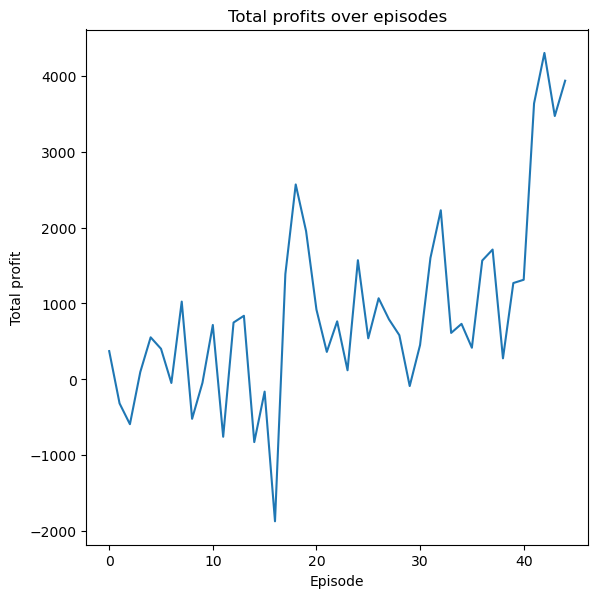

In [98]:
# DEFINE YOUR VISUALIZATION
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

#fig.suptitle("Total profits over episodes", fontsize=15)
fig.tight_layout(pad=2)

axs.plot(range(len(t_p)-5), t_p[:-5],)
axs.set_title("Total profits over episodes")
axs.set_xlabel("Episode")
axs.set_ylabel("Total profit")

In [115]:
def getState(data, t, n):
    window = data[100+t-n+1:100+t + 1]
    return window.reshape((1, n))


In [106]:
process3_traces = process3_price_traces(
    start_price=100,
    alpha3=1,
    time_steps=10000,
    num_traces=1000
)

In [119]:
data = process3_traces # np.ndarray
window_size = 100 # state space size, consist with previous window_size days
agent = Agent(window_size)
num_episodes = 1000
l = len(data) - 101
batch_size = 32
t_p = []
for i_episode in range(num_episodes):
    print("Episode " + str(i_episode) + "/" + str(num_episodes))
    state = getState(data[i_episode], 0, window_size)
    total_profit = 0
    agent.inventory = []
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data[i_episode], t + 1, window_size)#) + 1)
        reward = 0
        if action == 1: # buy
            agent.inventory.append(data[i_episode][t])
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0)
            # positive income from the transactions or 0
            reward = max(data[i_episode][t] - bought_price, 0)
            # cumulative profit for the episode
            total_profit += data[i_episode][t] - bought_price
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            t_p.append(total_profit)
    if i_episode % 50 == 0:
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
        #agent.model.save(str(i_episode))


Episode 0/1000
INFO:tensorflow:Assets written to: 0/assets
Episode 1/1000
Episode 2/1000
Episode 3/1000
Episode 4/1000
Episode 5/1000
Episode 6/1000
Episode 7/1000
Episode 8/1000
Episode 9/1000
Episode 10/1000
INFO:tensorflow:Assets written to: 10/assets
Episode 11/1000
Episode 12/1000
Episode 13/1000
Episode 14/1000
Episode 15/1000
Episode 16/1000
Episode 17/1000
Episode 18/1000
Episode 19/1000
Episode 20/1000
INFO:tensorflow:Assets written to: 20/assets
Episode 21/1000
Episode 22/1000
Episode 23/1000
Episode 24/1000
Episode 25/1000
Episode 26/1000
Episode 27/1000
Episode 28/1000
Episode 29/1000
Episode 30/1000
INFO:tensorflow:Assets written to: 30/assets
Episode 31/1000
Episode 32/1000
Episode 33/1000
Episode 34/1000
Episode 35/1000
Episode 36/1000
Episode 37/1000
Episode 38/1000
Episode 39/1000
Episode 40/1000
INFO:tensorflow:Assets written to: 40/assets
Episode 41/1000
Episode 42/1000
Episode 43/1000
Episode 44/1000
Episode 45/1000
Episode 46/1000
Episode 47/1000
Episode 48/1000
Ep

KeyboardInterrupt: 

Text(37.597222222222214, 0.5, 'Total profit')

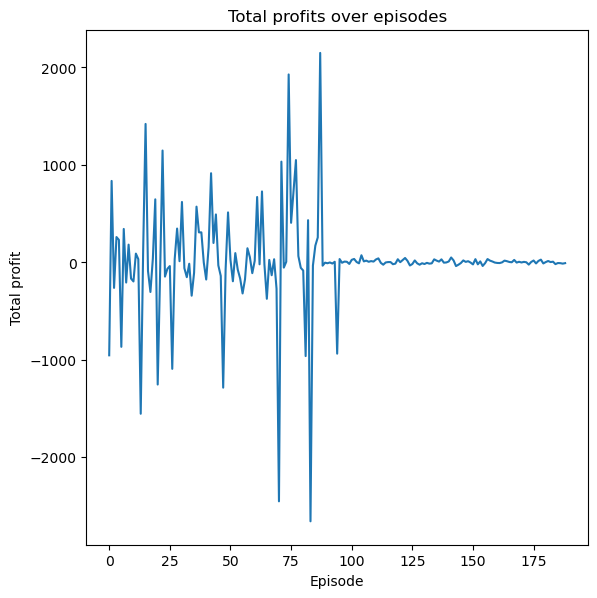

In [241]:
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

#fig.suptitle("Total profits over episodes", fontsize=15)
fig.tight_layout(pad=2)

axs.plot(range(len(t_p)), t_p,)
axs.set_title("Total profits over episodes")
axs.set_xlabel("Episode")
axs.set_ylabel("Total profit")

In [136]:
np.array(agent.loss_l).reshape(1, 5852)

array([[2.80665601e+03, 4.20798492e+02, 2.43459523e-01, ...,
        7.49814853e-06, 1.11683876e-04, 7.49904393e-06]])

In [148]:
vector_norm = agent.loss_l/np.linalg.norm(agent.loss_l)

Text(37.597222222222214, 0.5, 'Training Loss')

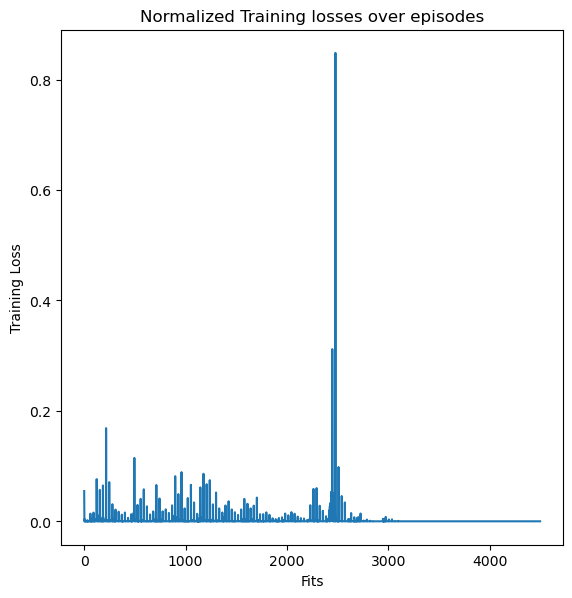

In [242]:
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

fig.tight_layout(pad=2)

axs.plot(np.array(range(4500)).astype(int), vector_norm[:4500])#list(np.array(agent.loss_l)),)
axs.set_title("Normalized Training losses over episodes")
axs.set_xlabel("Fits")
axs.set_ylabel("Training Loss")


## Time series model

In [116]:
# import section
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

def create_RNN(hidden_units, dense_units, input_shape, activation):

    # initiate the model for sequential data
    model = Sequential()

    # add model parameters to the simpleRNN layer
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,)) #)activation=activation[0]))

    # add model parameter to the dense layer
    model.add(Dense(units=dense_units,)) # activation=activation[1]))

    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

"""
    keras LSTM
    The function returns a model that includes a LSTM layer and a Dense layer
    for learning sequential data.
"""

def create_LSTM(hidden_units, dense_units, input_shape, activation):

    # initiate model
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,))# activation=activation[0]))
    model.add(Dense(units=dense_units,))# activation=activation[1]))
    model.compile(optimizer = "RMSprop", loss = 'mae')

    return model

"""
    keras LSTM
    The function returns a model that includes a GRU layer and a Dense layer
    for learning sequential data.
"""

def create_GRU(hidden_units, dense_units, input_shape, activation):

    # initiate model
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, ))#activation=activation[0]))
    model.add(Dense(units=dense_units, ))#activation=activation[1]))
    model.compile(optimizer = "RMSprop", loss = 'mae')

    return model

In [96]:
data_hist = yf.download("GOOG", start="2021-04-28", end="2023-04-25", interval="1h")

[*********************100%***********************]  1 of 1 completed


In [88]:
from pandas import read_csv
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [97]:
df = data_hist['Close']

In [104]:
df = data_hist.filter(['Close'], axis=1)

In [127]:
def get_train_test(data, split_percent = 0.8):
    # read in the data
    #df = read_csv(url, usecols=[1], engine='python')
    # change the all the data to float type and add into new object
    #data = np.array(df.values.astype('float32'))
    # set the scaler for the data
    #scaler = MinMaxScaler(feature_range=(0,1))
    # scale the data
    #data = scaler.fit_transform(data).flatten()
    # variable to keep the length of the data
    n = len(data)
    # Potin for splitting data into train and time_steps
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

train_data, test_data, data = get_train_test(df['Close'].values)#process3_traces[0]

def get_XY(dat, time_steps):
    # indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_steps = 5
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)


In [128]:
#model_type = "Simple RNN"
#model_type = "LSTM"
model_type = "GRU"

if model_type == "Simple RNN":
    model = create_RNN(hidden_units=32, dense_units=1, input_shape=(time_steps,1), activation=['relu', 'relu'])
elif model_type == "LSTM":
    model = create_LSTM(hidden_units=32, dense_units=1, input_shape=(time_steps,1), activation=['relu', 'relu'])
elif model_type == "GRU":
    model = create_GRU(hidden_units=32, dense_units=1, input_shape=(time_steps,1), activation=['relu', 'relu'])

# fitting models
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)

In [129]:
# Compute and print the root mean square error
def print_error(trainY, testY, train_predict, test_predict):
    # error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # print RMSE
    print('Train RMSE %.3f RMSE' % (train_rmse))
    print('Test RMSE %.3f RMSE' % (test_rmse))

# make the predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# mean square error
print_error(trainY, testY, train_predict, test_predict)

5/5 [==============================] - 0s 1ms/step
Train RMSE 2.410 RMSE
Test RMSE 2.273 RMSE


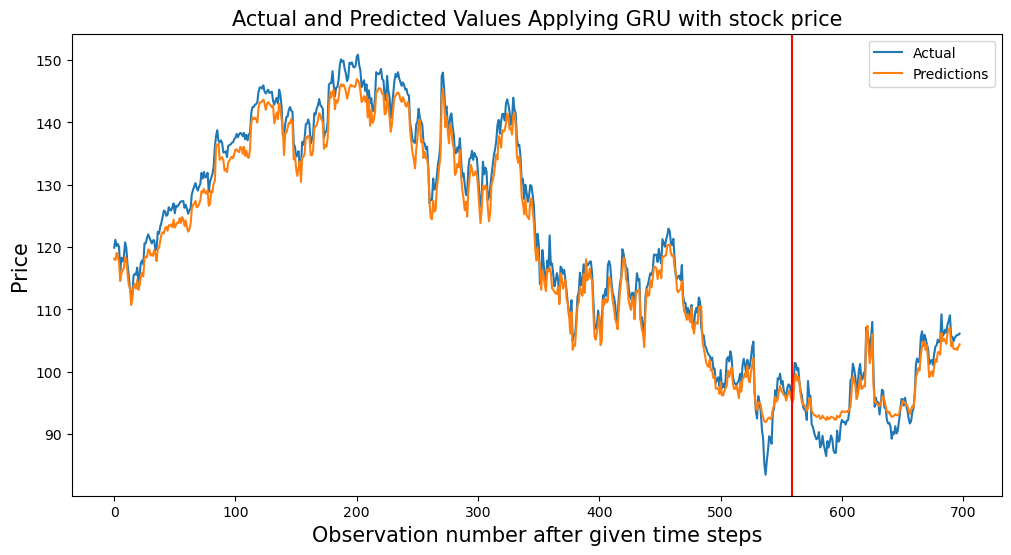

In [131]:
# view the result
def plot_result(trainY, testY, train_predict, test_precit):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows=len(actual)
    plt.figure(figsize=(12,6))
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color = 'r')
    plt.legend(['Actual', 'Predictions'],fontsize=10)
    plt.xlabel('Observation number after given time steps',fontsize=15)
    plt.ylabel('Price',fontsize=15)
    plt.title('Actual and Predicted Values Applying '+model_type + ' with simulated stock price', fontsize=15)
    plt.show()


plot_result(trainY, testY, train_predict, test_predict)

## using RNN

In [14]:
GOOG = yf.download("GOOG", start="2023-1-25", end="2023-04-25", interval="1h")
GOOG = GOOG['Adj Close']# - sp500['Open']
GOOG = GOOG.values

[*********************100%***********************]  1 of 1 completed


## Simulate a live trading situation

In [16]:
ticker = yf.Ticker('GOOG').info['currentPrice']
ticker

107.825

In [65]:
class Agent:
        def __init__(self):
            self.state_size = 5 # normalized previous days
            self.action_size = 3 # sit, buy, sell
            self.memory = deque(maxlen=1000)
            self.inventory = []
            self.model = self._model()
            self.gamma = 0.95
            self.epsilon = 1.0
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.995
            self.loss_l = []
            self.val_loss_l = []

        def _model(self):
            model = Sequential()
            model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
            model.add(Dense(units=32, activation="relu"))
            model.add(Dense(units=8, activation="relu"))
            model.add(Dense(self.action_size, activation="linear"))
            model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
            return model

        def act(self, state):
            if random.random()<= self.epsilon:
                return random.randrange(self.action_size)
            options = self.model.predict(state, verbose=0)
            return np.argmax(options[0])

        def opt_model(self):

            state_l = []
            y_f_l = []

            for state, action, reward, next_state in self.memory:

                state_l.append(state)
                y = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]),verbose=0)[0])
                y_f = self.model.predict(np.array([state]), verbose=0)
                y_f[0][action] = y
                y_f_l.append(y_f)

            train_history = self.model.fit(np.array(state_l), np.array(y_f_l), epochs=1, verbose=0)
            self.loss_l.append(train_history.history['loss'])
            #self.val_loss_l.append(train_history.history['val_loss'])

            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

In [152]:
GOOG = yf.download("GOOG", start="2023-1-25", end="2023-04-25", interval="1h")
GOOG = GOOG['Adj Close']# - sp500['Open']
GOOG = GOOG.values
data_hist = GOOG
ticker = yf.Ticker('GOOG').info['currentPrice']

In [31]:
def getState(data, t, n):
    window = data[5+t-n+1:5+t + 1]
    return window

In [55]:
data_hist[-5:]

In [197]:
window_size = 5  # state space size, consist with previous window_size days
agent = Agent()
t_p = []

for i in range(1000):

    #state = getState(data_hist, len(data_hist) -1 - window_size, window_size)
    state = data_hist[-5:]
    total_profit = 0
    agent.inventory = []
    for t in range(5):
        action = agent.act(state)
        reward = 0
        current_price = yf.Ticker('EURUSD=X').info['ask']
        # sit
        if action == 0:
            print("Sit")
        # buy
        elif action == 1:
            if len(agent.inventory) == 0:
                agent.inventory.append(current_price)
            else:
                agent.inventory[0] += current_price
            print("Buy: " + str(current_price))
        # sell
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = window_size_price = agent.inventory.pop(0)
            reward = max(current_price - bought_price, 0)
            total_profit += current_price - bought_price
            t_p.append(total_profit)
            print("Sell: " + str(current_price) + " | Profit: " + str(float(current_price - bought_price)))

        if action == 2 and len(agent.inventory) >= 0:
            print("Sell on empty inventory")

        data_hist = np.append(data_hist, current_price)
        #next_state = getState(data_hist, len(data_hist) -1 - window_size, window_size)
        next_state = data_hist[-5:]
        #done = False
        agent.memory.append((state, action, reward, next_state))
        state = next_state

        time.sleep(2)

    print("-----------------Policy optimization -" + str(i) + "- ----------------")
    agent.opt_model()

In [177]:
yf.Ticker('^DJI').info['currentPrice']

In [194]:
yf.Ticker('GOOG').info['ask']

In [133]:
from dataclasses import dataclass
from typing import Optional, Mapping, Sequence, Tuple
from collections import Counter
import numpy as np
from numpy.random import binomial
import itertools
from operator import itemgetter
from rl.gen_utils.common_funcs import get_logistic_func, get_unit_sigmoid_func


@dataclass
class Process1:
    @dataclass
    class State:
        price: int

    level_param: int  # level to which price mean-reverts
    alpha1: float = 0.25  # strength of mean-reversion (non-negative value)

    def up_prob(self, state: State) -> float:
        return get_logistic_func(self.alpha1)(self.level_param - state.price)

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process1.State(price=state.price + up_move * 2 - 1)


handy_map: Mapping[Optional[bool], int] = {True: -1, False: 1, None: 0}


@dataclass
class Process2:
    @dataclass
    class State:
        price: int
        is_prev_move_up: Optional[bool]

    alpha2: float = 0.75  # strength of reverse-pull (value in [0,1])

    def up_prob(self, state: State) -> float:
        return 0.5 * (1 + self.alpha2 * handy_map[state.is_prev_move_up])

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process2.State(
            price=state.price + up_move * 2 - 1,
            is_prev_move_up=bool(up_move)
        )


@dataclass
class Process3:
    @dataclass
    class State:
        num_up_moves: int
        num_down_moves: int

    alpha3: float = 1.0  # strength of reverse-pull (non-negative value)

    def up_prob(self, state: State) -> float:
        total = state.num_up_moves + state.num_down_moves
        return get_unit_sigmoid_func(self.alpha3)(
            state.num_down_moves / total
        ) if total else 0.5

    def next_state(self, state: State) -> State:
        up_move: int = binomial(1, self.up_prob(state), 1)[0]
        return Process3.State(
            num_up_moves=state.num_up_moves + up_move,
            num_down_moves=state.num_down_moves + 1 - up_move
        )


def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)


def process1_price_traces(
        start_price: int,
        level_param: int,
        alpha1: float,
        time_steps: int,
        num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1=alpha1)
    start_state = Process1.State(price=start_price)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])


def process2_price_traces(
        start_price: int,
        alpha2: float,
        time_steps: int,
        num_traces: int
) -> np.ndarray:
    process = Process2(alpha2=alpha2)
    start_state = Process2.State(price=start_price, is_prev_move_up=None)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])


def process3_price_traces(
        start_price: int,
        alpha3: float,
        time_steps: int,
        num_traces: int
) -> np.ndarray:
    process = Process3(alpha3=alpha3)
    start_state = Process3.State(num_up_moves=0, num_down_moves=0)
    return np.vstack([
        np.fromiter((start_price + s.num_up_moves - s.num_down_moves
                     for s in itertools.islice(simulation(process, start_state),
                                               time_steps + 1)), float)
        for _ in range(num_traces)])


def plot_single_trace_all_processes(
        process1_trace: np.ndarray,
        process2_trace: np.ndarray,
        process3_trace: np.ndarray
) -> None:
    from rl.gen_utils.plot_funcs import plot_list_of_curves

    traces_len: int = len(process1_trace)

    plot_list_of_curves(
        [range(traces_len)] * 3,
        [process1_trace, process2_trace, process3_trace],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )


def get_terminal_histogram(
        price_traces: np.ndarray
) -> Tuple[Sequence[int], Sequence[int]]:
    pairs: Sequence[Tuple[int, int]] = sorted(
        list(Counter(price_traces[:, -1]).items()),
        key=itemgetter(0)
    )
    return [x for x, _ in pairs], [y for _, y in pairs]


def plot_distribution_at_time_all_processes(
        process1_traces: np.ndarray,
        process2_traces: np.ndarray,
        process3_traces: np.ndarray
) -> None:
    from rl.gen_utils.plot_funcs import plot_list_of_curves

    num_traces: int = len(process1_traces)
    time_steps: int = len(process1_traces[0]) - 1

    x1, y1 = get_terminal_histogram(process1_traces)
    x2, y2 = get_terminal_histogram(process2_traces)
    x3, y3 = get_terminal_histogram(process3_traces)

    plot_list_of_curves(
        [x1, x2, x3],
        [y1, y2, y3],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Terminal Stock Price",
        "Counts",
        f"Terminal Price Counts (T={time_steps:d}, Traces={num_traces:d})"
    )


if __name__ == '__main__':
    start_price: int = 100
    level_param: int = 100
    alpha1: float = 0.25
    alpha2: float = 0.75
    alpha3: float = 1.0
    time_steps: int = 100
    num_traces: int = 1000

    process1_traces: np.ndarray = process1_price_traces(
        start_price=start_price,
        level_param=level_param,
        alpha1=alpha1,
        time_steps=time_steps,
        num_traces=num_traces
    )
    process2_traces: np.ndarray = process2_price_traces(
        start_price=start_price,
        alpha2=alpha2,
        time_steps=time_steps,
        num_traces=num_traces
    )
    process3_traces: np.ndarray = process3_price_traces(
        start_price=start_price,
        alpha3=alpha3,
        time_steps=time_steps,
        num_traces=num_traces
    )



In [138]:
process3_traces: np.ndarray = process3_price_traces(
    start_price=start_price,
    alpha3=alpha3,
    time_steps=3500,
    num_traces=1
)

In [146]:
train_data, test_data, data = get_train_test(df_log.values)#process3_traces[0]

In [147]:
model_type = "GRU"

if model_type == "Simple RNN":
    model = create_RNN(hidden_units=32, dense_units=1, input_shape=(time_steps,1), activation=['relu', 'relu'])
elif model_type == "LSTM":
    model = create_LSTM(hidden_units=32, dense_units=1, input_shape=(time_steps,1), activation=['relu', 'relu'])
elif model_type == "GRU":
    model = create_GRU(hidden_units=32, dense_units=1, input_shape=(time_steps,1), activation=['relu', 'relu'])


In [148]:
# make the predictions
time_steps = 5
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# mean square error
print_error(trainY, testY, train_predict, test_predict)

5/5 [==============================] - 0s 1ms/step
Train RMSE 0.065 RMSE
Test RMSE 0.070 RMSE


In [149]:
def plot_result(trainY, testY, train_predict, test_precit):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows=len(actual)
    plt.figure(figsize=(12,6))
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color = 'r')
    plt.legend(['Actual', 'Predictions'],fontsize=10)
    plt.xlabel('Observation number after given time steps',fontsize=15)
    plt.ylabel('Price',fontsize=15)
    plt.title('Actual and Predicted Values Applying '+model_type + ' with logged stock price', fontsize=15)
    plt.show()


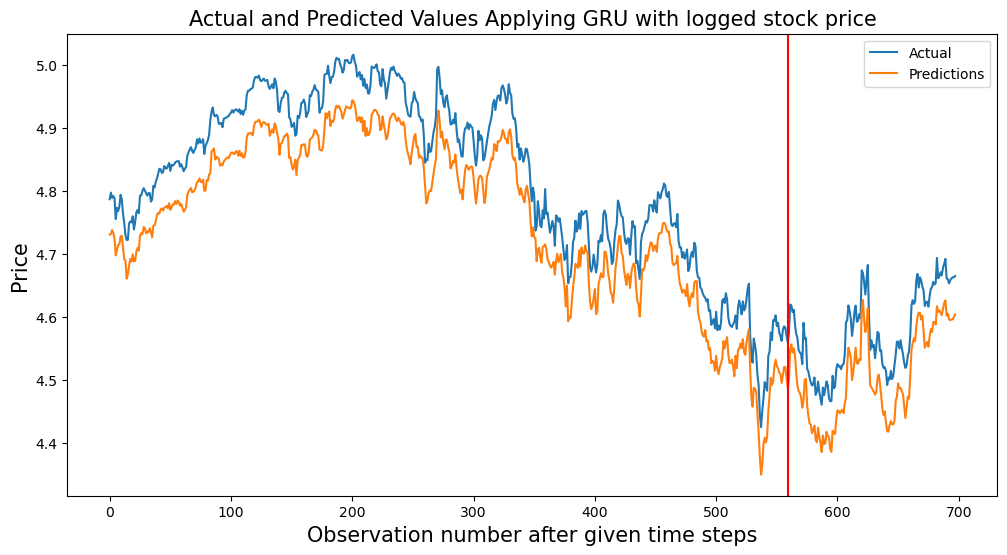

In [150]:
plot_result(trainY, testY, train_predict, test_predict)